# Assignment 2: predicting the prices of video games based on their screenshots
In this assignment, we embark on a deep learning project focused on analyzing image data sourced from games listed on the Steam Store. Our primary objective is to predict game prices based on the associated images, constituting a regression task. With a dataset including over 14,000 games and 125,000 images, we are presented with a rich and diverse pool of data for exploration.

The dataset has a list of attributes for each game, including its Steam ID (appid), release date, title, price in EUR cents, sentiment derived from user reviews, number of reviews, percentage of positive reviews, tags (categories or genres), and a list of filenames of screenshots associated with the game. In this project we are focus solely in the price labels and the screenshots of the videogames.

We begin with preprocessing, addressing both tabular and image data. For the tabular data, we detect and handle outliers and standardize the values to mitigate the influence of extreme data points. Concurrently, we resize and normalize the images to ensure consistency and facilitate efficient model training.

Next, we partition the dataset into distinct training and testing sets based on the Steam ID (appid). This ensures the independence of games in the training and testing sets, preventing data leakage and enhancing the generalizability of our model. To further strengthen our model, we employ data augmentation techniques on the training images. These techniques include transformations such as rotation, shifting, zooming, and flipping, generating a diverse array of image variations that enrich the training data.

Constructing a Convolutional Neural Network (CNN) forms the core of our project. CNNs are particularly well-suited for image analysis tasks due to their hierarchical pattern recognition capabilities. By leveraging convolutional layers, our CNN is designed to extract salient features from the input images, which are crucial for predicting game prices.

Validating the results of our CNN model involves the use of evaluation metrics like Mean Absolute Error (MAE) and Mean Squared Error (MSE). These metrics provide quantitative insights into the model's accuracy in predicting game prices, allowing us to assess its performance effectively. Alongside evaluating predictive performance, we explore interpretability techniques to understand the inner workings of the CNN. These techniques help us identify the key image features that drive the model's predictions, offering transparency and insights into the decision-making process.

Finally, we deploy the trained CNN model to make predictions on the test data. This involves estimating game prices based on the associated images and comparing these predictions with actual prices. Through this comprehensive approach, our project aims to demonstrate the potential of deep learning techniques in analyzing image data and predicting game prices, providing valuable insights for stakeholders in the gaming industry.

In [ ]:
#installing packages in the virtual environment 
%pip install numpy
%pip install pandas
%pip install tensorflow
%pip install pillow
%pip install scikit-learn
%pip install matplotlib
%pip install nbconvert
%pip install ipykernel
%pip install seaborn
%pip install cv2
%pip install nbconvert
%pip install pandoc





In [46]:
#importing packages needed
import os
import random
import numpy as np

import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

from PIL import Image

import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNetV2, VGG16, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.models import Model 

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model


import warnings
warnings.filterwarnings("ignore")

# Set the random seed
tf.random.set_seed(1)


## Loading and preprocessing data
### Tabular data
We load tabular data containing videogame identifiers, prices, and additional features. We retain only the first two columns, appid and price, removing others as they are not utilized for neural network training. The dataset comprises information on 14687 videogames. However, due to inaccurately formatted appids containing commas or periods, our tabular dataset contains information on 14682 video games. Subsequently, a boxplot illustrates the distribution of videogame prices in EUR cents.

In [47]:
#load tabular data

# Load tabular data from JSON file
tabular_data_path = r"C:\Users\Bertita\OneDrive\Escritorio\Erasmus\Big_Data\Assignment_2\videogames_tabular.json"
#tabular_data_path = r"C:\Users\hendr\OneDrive\Documenten\KUL 24\Advanced Data Analytics\Assignment 2\dataset.json"

tabular_data = pd.read_json(tabular_data_path)

# Filter out unnecessary columns 
columns_to_keep = ['appid', 'price']
tabular_data = tabular_data[columns_to_keep]

# Remove rows where 'appid' contains commas or periods
tabular_data_filtered = tabular_data[~tabular_data['appid'].str.contains(r'[,.]')]

# Convert the 'appid' column to numeric type
tabular_data_filtered['appid'] = pd.to_numeric(tabular_data_filtered['appid'], errors='coerce')


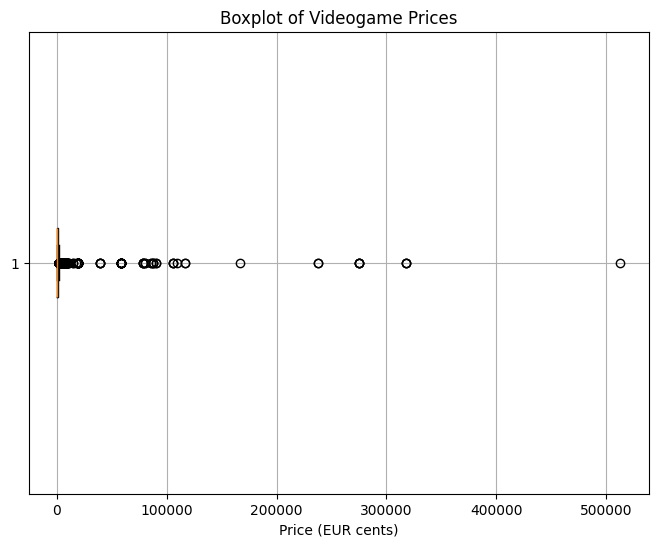

In [12]:
# Create a boxplot of the 'price' column
plt.figure(figsize=(8, 6))
plt.boxplot(tabular_data_filtered['price'], vert=False)
plt.title('Boxplot of Videogame Prices')
plt.xlabel('Price (EUR cents)')
plt.grid(True)
plt.show()



Observing the boxplot, we note the presence of rare events in our dataset, prompting us to do a deep analysis on them. 
In this Q-Q plot we can visualize the quantiles of video game prices. The x-axis represents the quantiles ranging from the 1st to the 100th percentile in steps of 1, and the y-axis represents the corresponding price values in EUR cents. 

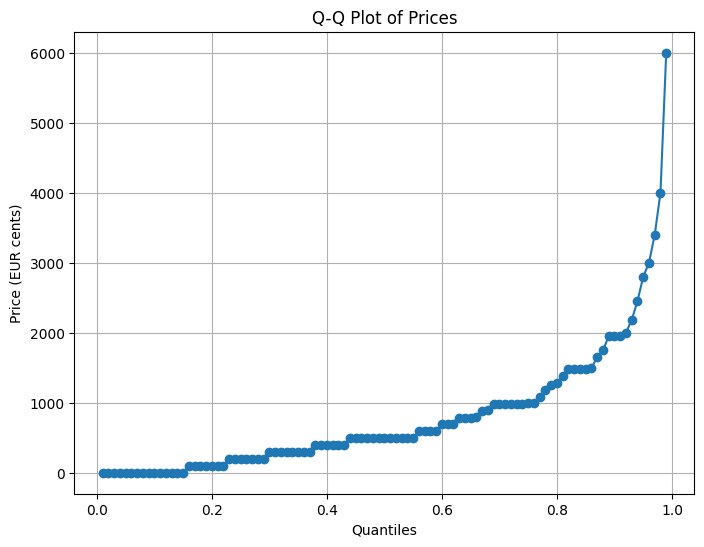

In [50]:
# Defining the quantiles
quantiles = np.arange(0.01, 1, 0.01)  

# Calculate the quantile values
quantile_values = tabular_data_filtered['price'].quantile(quantiles)

# Create a Q-Q plot
plt.figure(figsize=(8, 6))
plt.plot(quantiles, quantile_values, marker='o', linestyle='-')
plt.title('Q-Q Plot of Prices')
plt.xlabel('Quantiles')
plt.ylabel('Price (EUR cents)')
plt.grid(True)
plt.show()


Based on the analysis of the Q-Q plot, it is observed that 99% of the video game prices fall within the interval of 0 to 60 euros. AInitially, the exclusion of extreme data points was limited to the identification and rectification of potential data entry errors, under the assumption that neural networks demonstrate resilience towards outliers and to mitigate potential data bias.

To address this, a search was conducted on the historical maximum prices of video games on Steam. It was found that the highest historical price was 500,000€ for the game MEGAJUMP, and the second highest was 2000€. Considering that the first case is exceptionally rare, it is decided to remove all observations with prices exceeding 2000€. This approach ensures that extreme outliers, which are likely erroneous entries, are excluded from the dataset, while retaining the majority of the data for analysis. 

Additionally, it is pertinent to note that the analysis does not include the extreme left tail of the distribution because there are many free games, and there are no observations below 0 euros.

However, during the execution of our neural network model, it was observed that errors were notably elevated in the presence of extreme values, substantially diminishing upon their removal, given that they constitute less than 1% of the dataset, the final decision was to eliminate them.

In [32]:
num_beforeOutliers= len(tabular_data_filtered)

# Remove rows where the price is greater than 60 euros
tabular_data_filtered = tabular_data_filtered[tabular_data_filtered['price'] <= 6000]

removed_videogames= num_beforeOutliers - len(tabular_data_filtered)

#from now on we are using tabular_data_filtered
print("We have removed", removed_videogames, "observations from the original dataset due to potential data entry errors and rare events.")



We have removed 119 observations from the original dataset due to potential data entry errors and rare events.


In our model preparation, we also standardized the price values, ensuring they have a mean of 0 and a standard deviation of 1. This step aids optimization convergence, as it aligns the scales of the labels, promoting efficient learning. Standardization also enhances model interpretability by making coefficients directly comparable and less sensitive to the scale of the labels. Additionally, it improves model stability, mitigating the impact of outliers and contributes to a better predictive performance.

### Image data
We load the image paths from a specified folder and organize them by their associated appid in a dictionary. This allows us to efficiently manage and access image paths based on the unique identifiers of the video games. It's noteworthy that we have also removed images with incorrectly formatted appids containing commas or periods. We display here the first three games along with the respective counts of images extracted from our constructed dictionary.


In [33]:
image_paths = {}
image_folder = r"C:\Users\Bertita\OneDrive\Escritorio\Erasmus\Big_Data\images_be\images_small\images"

# Iterate over the files in the image folder
for filename in os.listdir(image_folder):
    appid = filename.split("_")[0]  # filename format is appid_imageindex.jpg
    # Ensure that the appid does not contain commas or periods
    if ',' not in appid and '.' not in appid:
            image_path = os.path.join(image_folder, filename)
            try:
                # Don't load image here, just store the path
                if appid not in image_paths:
                    image_paths[appid] = []
                image_paths[appid].append(image_path)
            except Exception as e:
                # If there is an error, print an error message and continue to the next image
                print(f"Error processing image {image_path}: {e}")
        


In [5]:
for index, (appid, paths) in enumerate(image_paths.items()):
    if index < 3:
        print(f"Game with appid {appid} has {len(paths)} images.")

Game with appid 1000410 has 13 images.
Game with appid 1000800 has 8 images.
Game with appid 1001270 has 21 images.


We have developed a function aimed at preparing our images for subsequent analysis. This function serves two primary purposes: resizing and normalization. Resizing ensures uniformity in image dimensions, which is crucial for facilitating the training process. Normalization, on the other hand, standardizes pixel values, thereby promoting stability during model training and enhancing convergence. Additionally, our function incorporates a step to add a background to the images. This process ensures that the images conform to the desired shape without compromising their content. Moreover, the function includes error handling mechanisms to address any exceptions encountered during image processing, displaying informative error messages for diagnostic purposes. Through these enhancements, our image batches are meticulously prepared for integration into our neural network framework, optimizing the efficiency and efficacy of subsequent analysis

To address the Out of Memory issue encountered during image processing, we've adopted a batch processing strategy. This approach involves dividing the image paths into smaller batches, mitigating the strain on memory resources by processing images incrementally. By batching image processing tasks, we effectively manage memory usage and prevent system overload. This optimization ensures smoother execution and minimizes the risk of memory-related errors, enhancing the reliability of our image preparation process. Additionally, this strategy seamlessly integrates with our existing workflow, preserving the integrity of our image processing pipeline while bolstering its efficiency and scalability.

In [5]:
def load_images_batch(image_paths, desired_width, desired_height):
    batch_images = []
    for image_path in image_paths:
        try:
            with Image.open(image_path) as img:
                # Resize the image while maintaining the aspect ratio
                img_resized = img.resize((desired_width, desired_height))

                # Crop and pad the image to have the same shape
                background = Image.new('RGB', (desired_width, desired_height), (255, 255, 255))  # Fill with white
                bg_w, bg_h = background.size
                img_w, img_h = img_resized.size
                offset = ((bg_w - img_w) // 2, (bg_h - img_h) // 2)
                background.paste(img_resized, offset)

                # Convert the image to a numpy array and normalize pixel values
                img_array = np.array(background).astype(np.float32) / 255.0

                batch_images.append(img_array)
                img.close()
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
    
    return batch_images

## Train and test split
First of all, we must make sure that our tabular data and image data correspond to the same set of video games to ensure that only video games present in both datasets are retained for further analysis.

In [34]:
# Get common appids
common_appids = set(image_paths.keys()).intersection(set(tabular_data['appid']))

# Filter image paths and tabular data
image_paths_common = {appid: paths for appid, paths in image_paths.items() if appid in common_appids}
tabular_data_common = tabular_data[tabular_data['appid'].isin(common_appids)]

# Convert common_appids set to a list
common_appids_list = list(common_appids)

print("There are", len(common_appids),  "common appids in tabular data and image data.")


There are 14682 common appids in tabular data and image data.


After ensuring alignment between the tabular and image datasets, we proceed to split them into training and testing sets. Here, 20% of the appids are allocated for testing, while the remaining 80% is designated for training. This division enables us to evaluate the performance of our models on unseen data and ensures robustness in our analysis. 

Here we are also replicating the labels for each image in both the training and testing sets. This practice ensures that each image is paired with its corresponding price label, facilitating accurate model training and evaluation. By replicating the labels, we maintain consistency between the images and their associated prices, enabling effective assessment of the model's ability to predict prices for unseen video games.

In [7]:
# Function to process images in batches
def process_images_in_batches(image_paths_dict, batch_size, desired_width, desired_height):
    for appid, paths in image_paths_dict.items():
        num_batches = len(paths) // batch_size
        if len(paths) % batch_size != 0:
            num_batches += 1
        
        for i in range(num_batches):
            batch_paths = paths[i * batch_size: (i + 1) * batch_size]
            batch_images = load_images_batch(batch_paths, desired_width, desired_height)
            yield appid, batch_images

# Split common appids into training and testing sets
train_appids, test_appids = train_test_split(common_appids_list, test_size=0.2, random_state=42)

desired_width, desired_height = 96, 96  #IDEALLY WITH THIS OR 128,160 OR MORE to match with MobileNet2 requirements
train_images, test_images = [], []
train_labels, test_labels = [], []

# Create a dictionary to store the resized and normalized images
resized_images_dict = {}

# Resize and normalize the images
for appid, paths in process_images_in_batches(image_paths_common, batch_size=20, desired_width=desired_width, desired_height=desired_height):
    resized_images_dict.setdefault(appid, []).extend(paths)

# Populate the train and test lists with images and labels (labels=price)
for appid, images in resized_images_dict.items():
    tabular_data_common.loc[:, 'appid'] = tabular_data_common['appid'].astype(int)
    labels = tabular_data_common.loc[tabular_data_common['appid'] == int(appid), 'price'].values
    if appid in train_appids:
        #train_images.extend(images)
        train_labels.extend([labels[0]] * len(images))  # Replicate label for each image
    else:
        test_images.extend(images)
        test_labels.extend([labels[0]] * len(images))  # Replicate label for each image

print("There are", len(train_appids), "videogames in the training set, and", len(test_appids), "on the testing set.")


There are 11745 videogames in the training set, and 2937 on the testing set.


In [8]:
# SAVE TRAIN AND TEST SETS
# #ONLY RUN THIS CHUNK WHEN YOU HAVE RUN THE PREVIOUS CHUNK IN THE SAME SESSION

#np.save('train_images.npy', np.array(train_images))
#np.save('train_labels.npy', np.array(train_labels))
np.save('test_images.npy', np.array(test_images))
np.save('test_labels.npy', np.array(test_labels))

#RESTART SESSION TO FREE UP MEMORY


In [14]:
# ONLY RUN THIS IF YOU ALREADY HAVE SAVED THE ARRAYS
# #Load train
train_images = np.load('train_images.npy')
train_labels = np.load('train_labels.npy')


Here we can examine some preprocessed images from the training set.

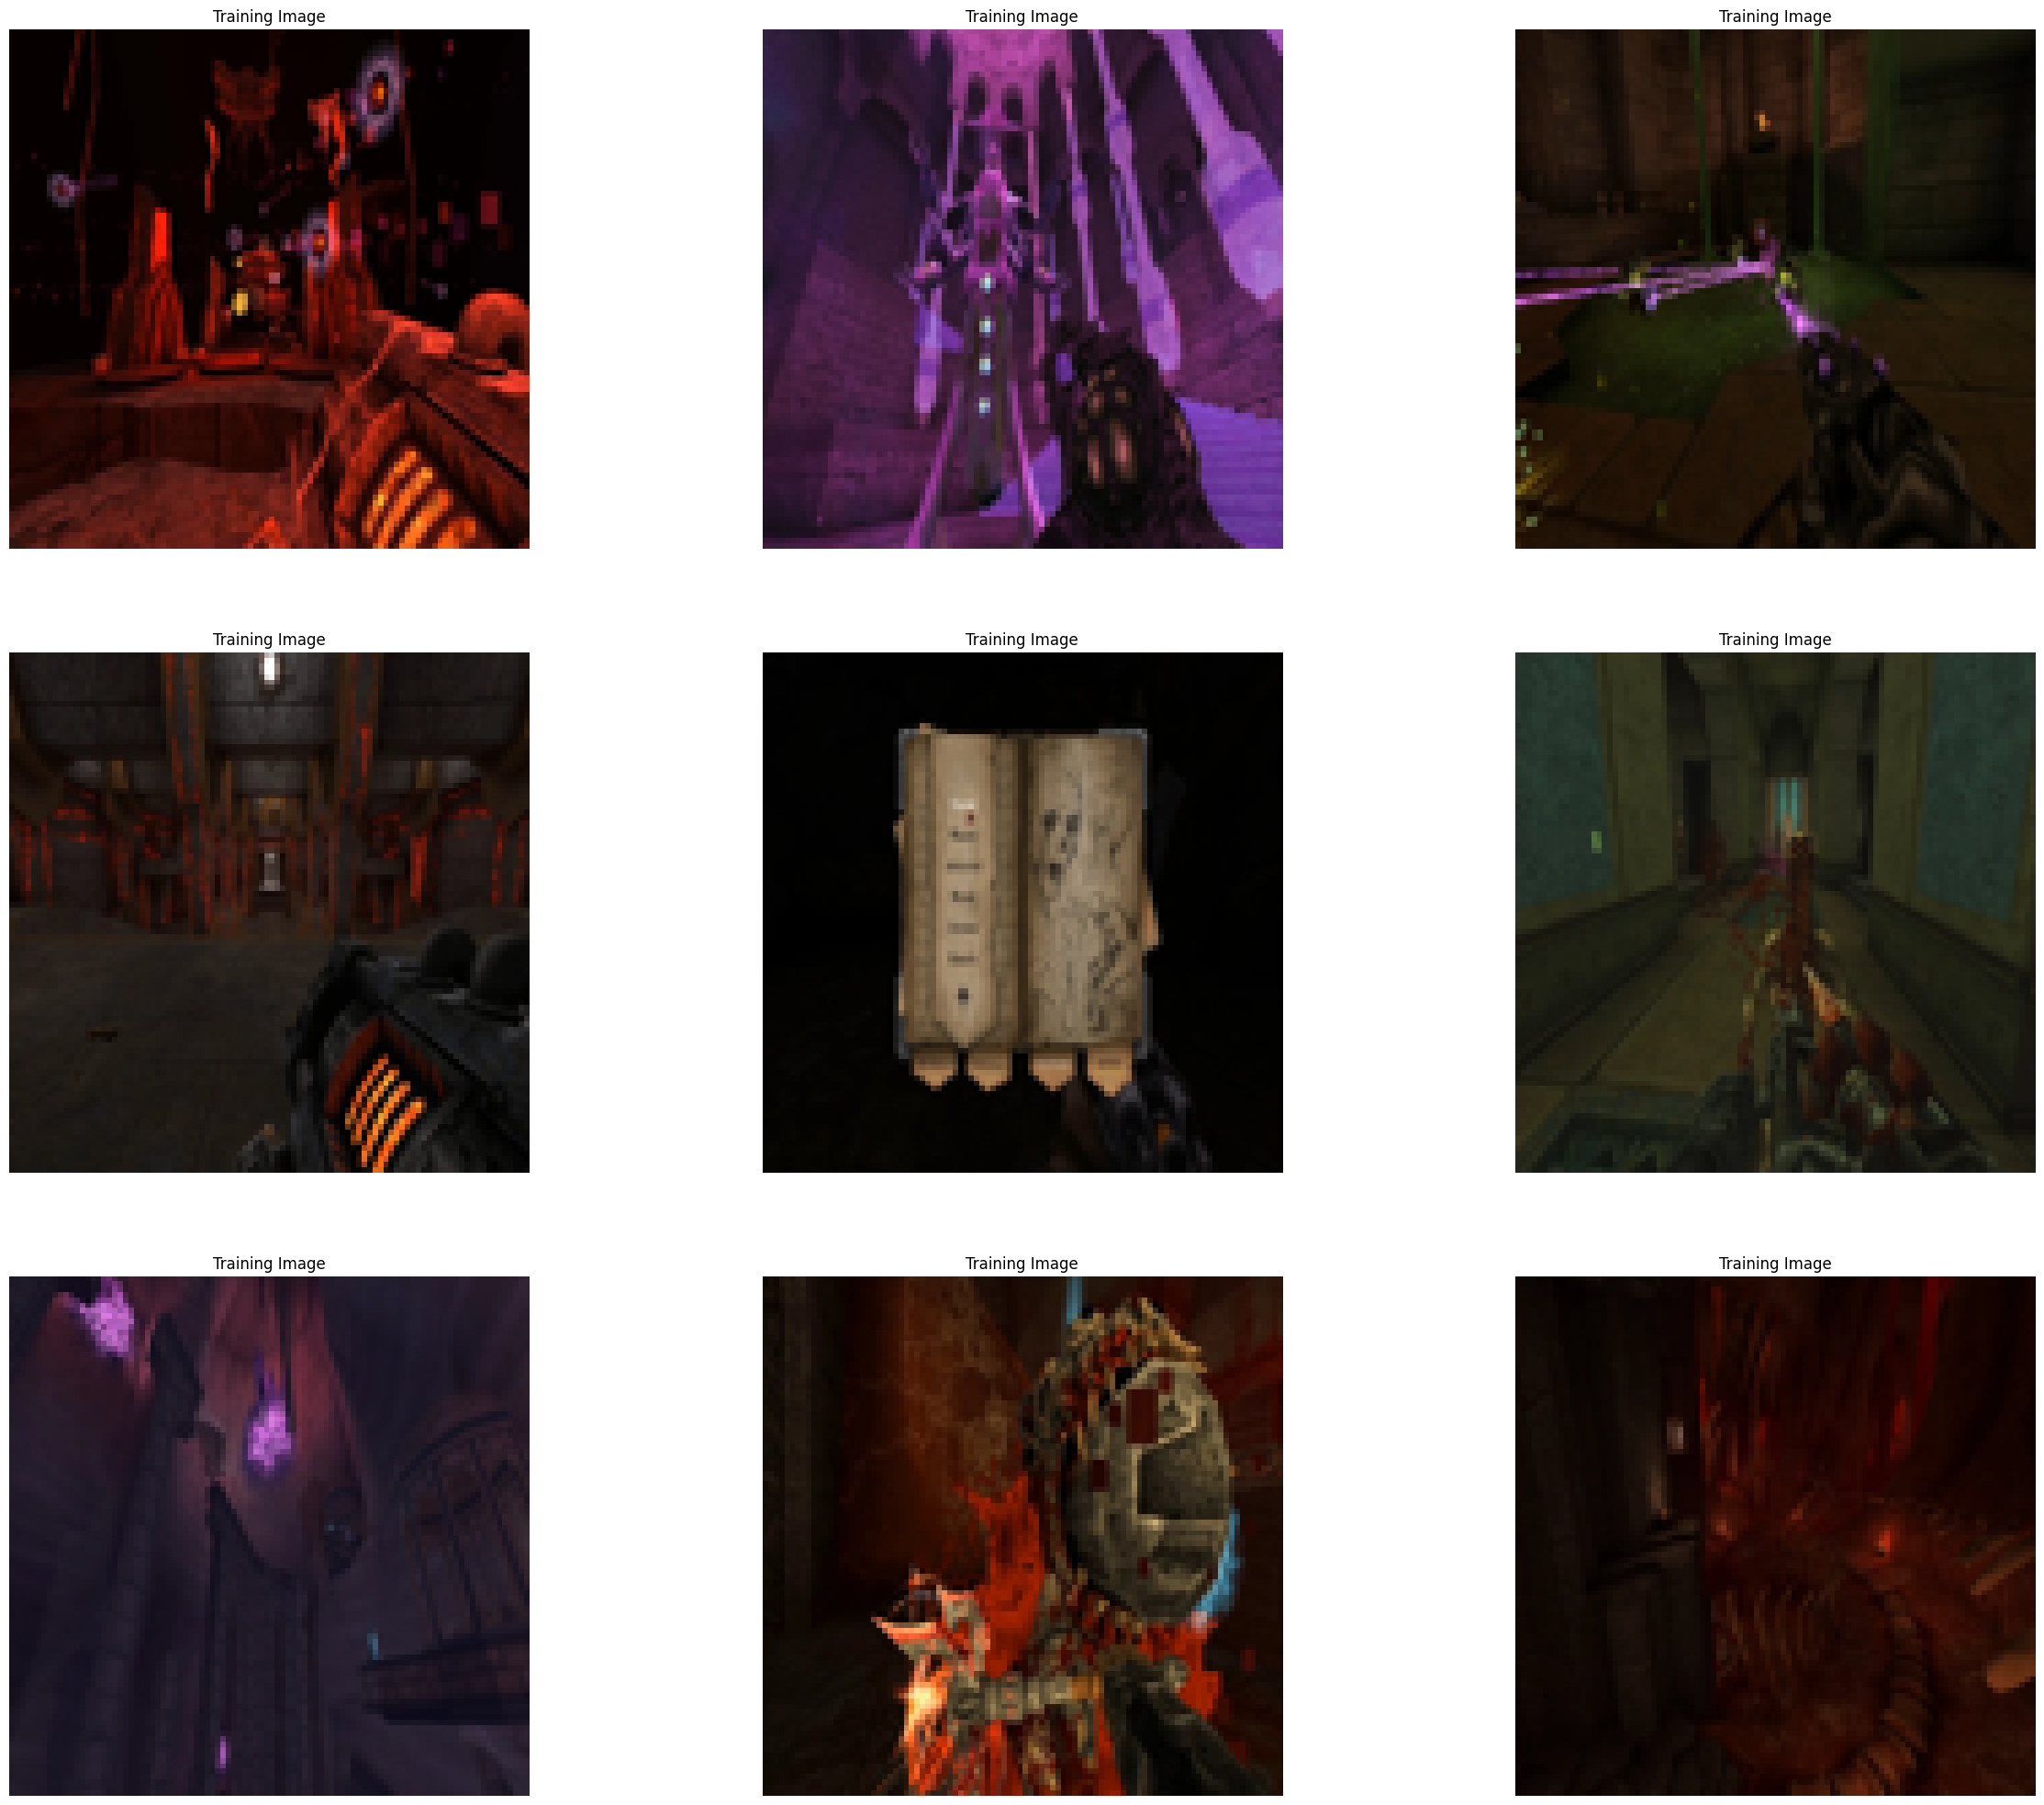

In [28]:
# Visualize the images
plt.figure(figsize=(30, 25))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i])
    plt.title('Training Image')
    plt.axis('off')
plt.show()

We have visualized some training images resized to 96x96 pixels. It's evident that this resolution lacks detail, potentially limiting the model's precision. The reduced resolution results in loss of fine-grained information, making it challenging for the model to capture intricate patterns and nuances in the images. Consequently, the model's ability to extract meaningful features and make accurate predictions is likely to be compromised. Higher resolutions typically offer richer visual information, enabling the model to discern subtle distinctions essential for precise predictions. Therefore, the limited resolution of the images may hinder the model's overall performance and predictive accuracy.

In this section, we provide an overview of the different shapes present within our image training dataset and the corresponding distribution of images across these shapes. This analysis enables us to understand the variability in image dimensions and assess the extent of diversity within our dataset. By presenting each unique image shape alongside the respective count of images, we gain insights into the dataset's composition and identify any irregularities or outliers that may warrant further investigation.

In [16]:
train_shape_counts = {}

# Count the number of images for each shape
for image in train_images:
    shape = image.shape[:2]  # Ignore the number of color channels
    if shape in train_shape_counts:
        train_shape_counts[shape] += 1
    else:
        train_shape_counts[shape] = 1

# Display the number of images for each shape
for shape, count in train_shape_counts.items():
    print(f"Shape: {shape}, Number of images: {count} in the training set")



Shape: (96, 96), Number of images: 102734 in the training set


We observe that there is only one image shape, 96x96, indicating that the resizing process has been successfully executed and the images have attained uniformity in shape as intended. We have chosen to resize images into 96x96 due to the Out of Memory issue. Consequently, all images exhibit the same dimensions and do not necessitate any further treatment. This uniformity ensures consistency in our dataset and validates the effectiveness of the resizing procedure in standardizing the image dimensions for subsequent analysis.

### Data augmentation 
Data augmentation is a technique aimed at enriching our training dataset by applying various transformations to the images. These transformations include rotations, shifts, shearing, zooming, and flips, among others. By introducing these variations, we effectively expand the diversity of our training data, enabling our model to learn from a broader range of scenarios and improving its ability to generalize to unseen data.

To ensure efficient implementation and mitigate memory constraints, we employ a batching process within our data augmentation pipeline. This process involves dividing the dataset into smaller batches and sequentially applying data augmentation to each batch. By processing the data in batches, we effectively manage memory usage and prevent potential issues, such as Out of Memory errors, ensuring smooth execution of the data augmentation process.

Our approach to data augmentation focuses exclusively on the training set, as this allows our model to learn from augmented samples while preserving the original validation and testing datasets for evaluation purposes.

In [ ]:
# Initialize ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images by up to 10 degrees
    width_shift_range=0.1,  # randomly shift images horizontally by up to 10% of the width
    height_shift_range=0.1,  # randomly shift images vertically by up to 10% of the height
    shear_range=0.1,  # apply shear transformation with maximum shear intensity of 10%
    zoom_range=0.1,  # randomly zoom into images by up to 10%
    horizontal_flip=True,  # randomly flip images horizontally
    fill_mode='nearest'  # strategy for filling in newly created pixels
)
def augment_data(images, labels, batch_size=20):
    augmented_images, augmented_labels = [], []
    # Convert images to a numpy array
    images = np.array(images)
    # Get the total number of images
    total_images = len(images)
    
    # Process the data in batches
    for i in range(0, total_images, batch_size):
        batch_images = images[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]
        
        # Perform data augmentation on the batch
        for augmented_batch in datagen.flow(batch_images, batch_labels, batch_size=batch_size):
            augmented_images.extend(augmented_batch[0])
            augmented_labels.extend(augmented_batch[1])
            break  # Exit the loop after processing one batch
        
    return np.array(augmented_images), np.array(augmented_labels)

# Apply data augmentation only to the training set
X_augmented_train_images, y_augmented_train = augment_data(train_images, train_labels)



In [ ]:
#save the augmented sets

np.save('X_augmented_train_images.npy', np.array(X_augmented_train_images))
np.save('y_augmented_train.npy', np.array(y_augmented_train))

In [3]:
#load the augmented sets
X_augmented_train_images = np.load('X_augmented_train_images.npy')
y_augmented_train = np.load('y_augmented_train.npy')

Here we can examine some augmented images from the training set.

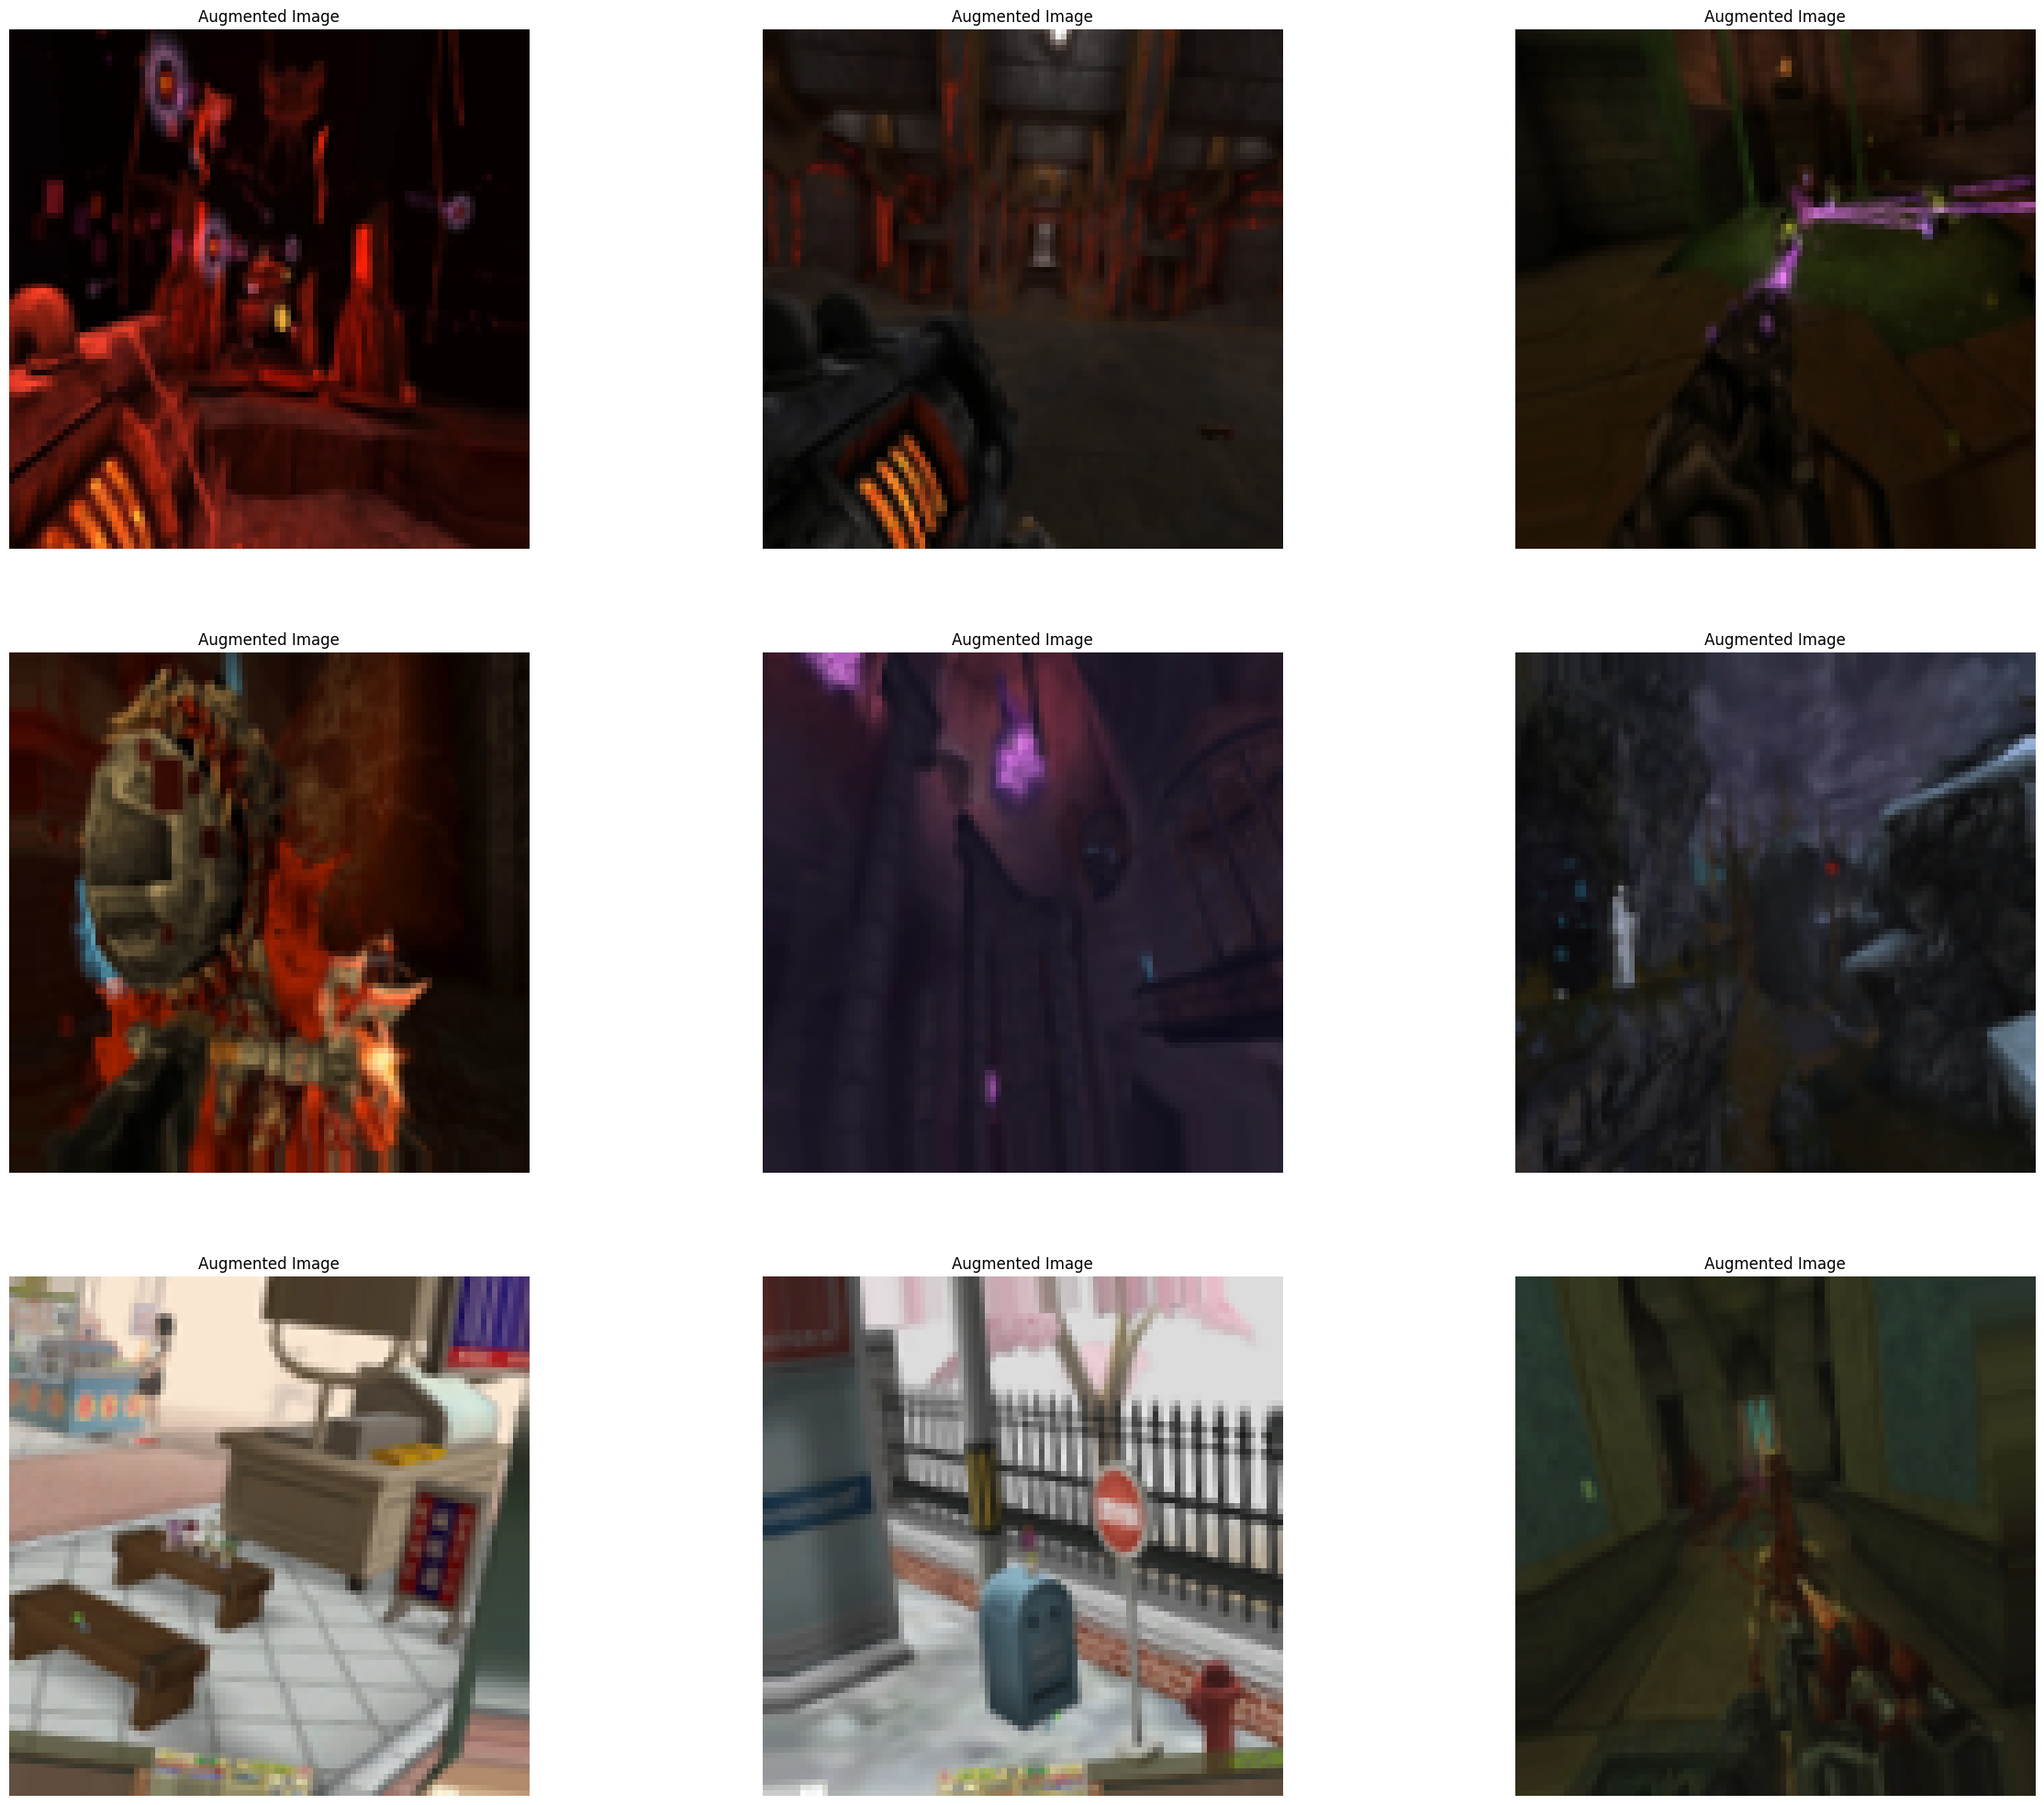

In [29]:
# Visualize the augmented images
plt.figure(figsize=(30, 25))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_augmented_train_images[i])
    plt.title('Augmented Image')
    plt.axis('off')
plt.show()

In [4]:
# Combine original and augmented images
X_combined_train_images = np.concatenate([train_images, X_augmented_train_images], axis=0)

# Combine original and augmented labels
y_combined_train = np.concatenate([train_labels, y_augmented_train], axis=0)

# Shuffle the combined data to ensure randomness
#combined_data = list(zip(X_combined_train_images, y_combined_train))
#random.shuffle(combined_data)
#X_combined_train_images, y_combined_train = zip(*combined_data)
#X_combined_train_images, y_combined_train = np.array(X_combined_train_images), np.array(y_combined_train)

# Now we can train the model using X_combined_train_images and y_combined_train


In [ ]:
#save
# standarizing training labels
scaler = StandardScaler()
y_combined_train = scaler.fit_transform(y_combined_train.reshape(-1, 1)).flatten()


np.save('X_combined_train_images.npy', np.array(X_combined_train_images))
np.save('y_combined_train.npy', np.array(y_combined_train))

In [3]:
#load, here are the final training datasets
X_combined_train_images = np.load('X_combined_train_images.npy')
y_combined_train = np.load('y_combined_train.npy')

In [ ]:
# variables to keep
variables_a_conservar = ['X_combined_train_images', 'y_combined_train']
# list every variable in the environment
variables_globales = list(globals().keys())

# delete all the variables in the environment except variables to keep
for variable in variables_globales:
    if variable not in variables_a_conservar:
        del globals()[variable]

#run again the importing packages chunk

Here, we are combining the original training images with the augmented images to create a more diverse and robust training dataset. By augmenting our data, we introduce variations that help the model learn to generalize better and become more robust to different input conditions. After combining the original and augmented images, we also merge their corresponding labels to maintain alignment. Finally, we shuffle the combined data to ensure randomness before training the model. This process enriches our training data and enhances the model's ability to learn from a wider range of examples.

## Constructing the Neural Network
In our mission to construct a robust regression model for our task, we are presented with two fundamental choices: leveraging a pre-trained model or constructing one from scratch. The decision to employ a pre-trained model, such as VGG16, VGG19, ResNet50, or MobileNetV2, stems from the inherent advantages it offers in terms of computational efficiency and performance. Pre-trained models have been meticulously trained on extensive datasets, often comprising millions of images, to learn generic features that are transferable across a wide range of tasks. By using pre-trained models as feature extractors, we tap into the knowledge stored in their parameters and this lets our model benefit from learned visual features without having to train extensively on our dataset. This process, known as transfer learning, streamlines our model development and enhances its effectiveness. We are using ImageNet weights, which are often used in transfer learning because they are widely applicable and highly effective.

Among the pre-trained models available, MobileNetV2 stands out for our application because of its lightweight design and efficient use of memory and computational resources. It is crafted specifically for mobile and embedded vision tasks, making it a perfect fit for our needs, especially considering our limited computing resources. By using MobileNetV2 as the foundation of our model, we find a balance between complexity and feasibility, ensuring that our regression model is both powerful and practical for real-world use.

### Structure of the Neural Network
We have constructed a neural network using TensorFlow and Keras to address our regression task. This model architecture is structured as follows: firstly, we incorporate a pre-trained model from TensorFlow's Keras applications, specifically MobileNetV2, chosen for its efficient design and suitability for our application.

The neural network we have constructed is structured sequentially, starting with MobileNetV2 as the primary feature extractor for our image data. In this setup, we kept MobileNetV2 layers non-trainable to retain their pre-trained weights, ensuring that the initial feature extraction benefits from the extensive training on the ImageNet dataset. Following MobileNetV2, we added a convolutional layer with 64 filters and a 3x3 kernel size, using the ReLU activation function and 'same' padding to preserve the spatial dimensions of the input. This is followed by batch normalization to standardize the activations, which helps in accelerating training and improving model stability.

Next, the global average pooling layer reduces the dimensionality of the feature maps by computing the average of each feature map, summarizing the information efficiently. Dense layers are then integrated, starting with a layer of 128 neurons activated by ReLU, coupled with L2 regularization to mitigate overfitting. A dropout layer with a 60% dropout rate is included to further prevent overfitting by randomly dropping neurons during training. The subsequent dense layer has 64 neurons, also using ReLU activation and L2 regularization, followed by another dropout layer with a 70% dropout rate. The model is concluded with an output layer featuring a single neuron and a linear activation function, which is well-suited for regression tasks.

Upon model compilation, we employ the Adam optimizer and specify the mean squared error (MSE) as the loss function, accompanied by mean absolute error (MAE) as an auxiliary metric for evaluation purposes. We use MSE because it effectively penalizes large errors by squaring the differences between predicted and actual values, ensuring the model prioritizes accurate predictions. MSE's smooth and differentiable nature facilitates efficient gradient-based optimization, enhancing the training process. Additionally, MSE provides a clear, unbiased measure of prediction accuracy across the dataset, making it a reliable metric for evaluating model performance.

We have chosen the Adam optimizer due to its adaptive learning rate capabilities and robust performance across various deep learning tasks. While experimenting, we also tried other common optimizers like SGD (Stochastic Gradient Descent) with momentum and RMSprop. However, Adam consistently yielded the best results, providing faster convergence and better overall model accuracy in our scenario. Its ability to adjust the learning rate dynamically for each parameter makes it particularly effective for training complex models, further justifying our choice.

Due to computational constraints, we have not performed an extensive hyperparameter tuning or grid search to optimize values like the regularization parameter, batch size, epochs, and other hyperparameters. These processes require substantial computational resources and time to systematically search through a predefined set of hyperparameters to find the best combination. Given our limited computing power, we tried several different values for these parameters and found the current values to be the most effective ones. This approach allows us to build and train our model within our resource limits while still achieving reasonable performance.

We have extensively experimented with various CNN architectures, ranging from simpler to more complex designs, incorporating different types of layers and configurations. These explorations involved exploring diverse architectures, varying layer types, and experimenting with different layer orders to obtain the most effective model configuration. Through rigorous experimentation, we found that the current architecture consistently outperformed other alternatives, demonstrating superior predictive performance. However, it's crucial to note that our experimentation was constrained by computational limitations, which restricted the depth and complexity of the architectures we could explore. Additionally, it's important to acknowledge that our model's performance could potentially be further enhanced with access to greater computational power, particularly for processing larger image sizes.



In [4]:
# Load pre-trained model
pretrained_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
pretrained_model.trainable = False

# Learning rate warmup and annealing
initial_learning_rate = 1e-4

def lr_schedule(epoch):
    if epoch < 5:
        return float(initial_learning_rate)
    else:
        return float(initial_learning_rate * tf.math.exp(0.1 * (5 - epoch)).numpy())

lr_scheduler = LearningRateScheduler(lr_schedule)


In [ ]:
#15 epochs 90min
# Build the model
model = Sequential([
  pretrained_model,
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(0.6),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.03)),
    Dropout(0.7),  # Dropout regularization
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    Dropout(0.7),
    Dense(1, activation='linear')
])

optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the model with additional metrics
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Train the model with early stopping and learning rate scheduler
history = model.fit(X_combined_train_images, y_combined_train, epochs=6, batch_size=32, 
                    validation_split=0.2, callbacks=[lr_scheduler])


In [ ]:
#model.save('my_model.keras')

#loading model in a new session

model = load_model('my_model.keras')


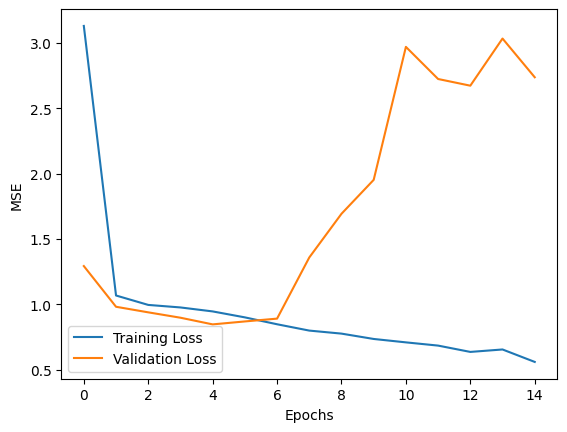

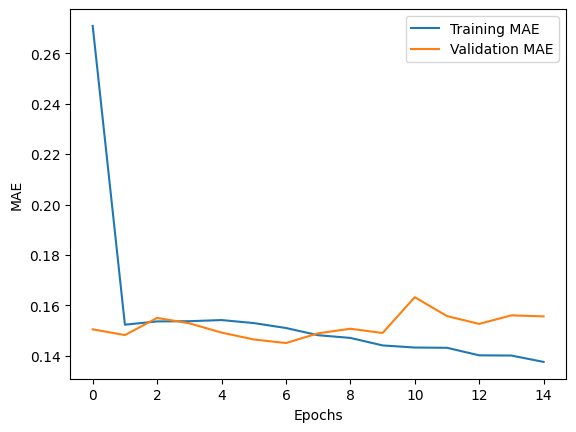

In [7]:
#plotting the training and validation loss over epochs

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

After running our CNN, we generated a graph depicting the Mean Absolute Error (MAE) and Mean Squared Error (MSE) metrics across epochs for both the training set and the validation split. This visualization allows us to observe the behavior of these metrics over the course of training and assess the presence of overfitting. We noticed that around epoch 5, both MAE and MSE are close to their minimum values, indicating optimal performance. This epoch also corresponds to the point where overfitting appears to be minimized, as the discrepancy between the training set and validation split metrics is relatively small. These insights help us identify a suitable epoch for achieving a balance between model performance and generalization ability.

## Predicting on testing data
After training and validating our regression model, the next crucial step is to evaluate its performance on an independent testing set. This evaluation provides an unbiased estimate of how well our model generalizes to new, unseen data, which is essential for assessing its practical utility. We use the trained model to make predictions on the test images and then compare these predictions with the true labels to determine the model's accuracy and error metrics. By analyzing the test loss and mean absolute error (MAE), we gain insights into the model's predictive capabilities and identify areas where further improvements may be needed. This step is vital for ensuring that our model is reliable and effective in real-world applications.

In [17]:
test_images = np.load('test_images.npy')
test_labels = np.load('test_labels.npy')

In [5]:
# Make predictions
from sklearn.metrics import mean_squared_error, mean_absolute_error

test_labels_scaled = scaler.fit_transform(test_labels.reshape(-1, 1)).flatten()

predictions_scaled = model.predict(test_images)

# Evaluate the model on test data (standardized labels)
test_loss, test_mae = model.evaluate(test_images, test_labels_scaled)

print(f"Test Loss (MSE in standardized scale) in testing data: {test_loss}")
print(f"Test MAE (MAE in standardized scale) in testing data: {test_mae}")

# De-standardize the predictions
predictions = scaler.inverse_transform(predictions_scaled)

# Calculate MSE and MAE in the original scale
mse_original = mean_squared_error(test_labels, predictions)
mae_original = mean_absolute_error(test_labels, predictions)

print(f"Test Loss (MSE in original scale): {mse_original}")
print(f"Test MAE (MAE in original scale): {mae_original}")



797/797 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step
797/797 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - loss: 0.7843 - mae: 0.1467
Test Loss (MSE in standardized scale) in testing data: 0.8150278925895691
Test MAE (MAE in standardized scale) in testing data: 0.1500021070241928
Test Loss (MSE in original scale): 47632534.966557905
Test MAE (MAE in original scale): 1158.3438329823443


The mean squared error (MSE) in the standardized scale, with a value of approximately 0.815, indicates the average squared difference between the model's predictions and the true values, offering a measure of prediction accuracy. Additionally, the mean absolute error (MAE) in the standardized scale, at around 0.150, represents the average absolute difference between predicted and true values, providing further assessment of the model's predictive capability. Converting these metrics to the original scale reveals a test MSE of approximately 47,632,534.97 and a test MAE of approximately 1,158.34 EUR cents. If we convert these values to EUR, we obtain a MAE of 11.5834, which means that the average absolute error of the prediction is of 11.5834 EUR. Moreover, computing the RMSE yields a value of approximately 69.01 EUR. While the MAE provides a straightforward measure of the average absolute deviation between predicted and true values the RMSE incorporates the squared errors, emphasizing larger deviations due to the squaring effect. Consequently, the RMSE tends to be more sensitive to outliers or large errors compared to the MAE, causing substantial differences between the both metrics. 

In [17]:

# Calculate basic summary statistics
count = len(test_labels)
mean = np.mean(test_labels)
median = np.median(test_labels)
minimum = np.min(test_labels)
maximum = np.max(test_labels)
std_dev = np.std(test_labels)

# Print the summary
print("Summary of Prices in Testing set:")
print(f"Count: {count}")
print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Minimum: {minimum}")
print(f"Maximum: {maximum}")
print(f"Standard Deviation: {std_dev}")


Summary of Prices in Testing set:
Count: 25499
Mean: 1239.5491195733166
Median: 499.0
Minimum: 0
Maximum: 317700
Standard Deviation: 7722.179272489626


In [16]:

# Calculate basic summary statistics
count = len(predictions)
mean = np.mean(predictions)
median = np.median(predictions)
minimum = np.min(predictions)
maximum = np.max(predictions)
std_dev = np.std(predictions)

# Print the summary
print("Summary of Predictions:")
print(f"Count: {count}")
print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Minimum: {minimum}")
print(f"Maximum: {maximum}")
print(f"Standard Deviation: {std_dev}")

Summary of Predictions:
Count: 25499
Mean: 1248.8740234375
Median: 977.3145751953125
Minimum: 977.1527099609375
Maximum: 197251.703125
Standard Deviation: 2771.187255859375


The summary statistics of the model predictions and the test labels reveal notable differences and similarities. The mean prediction value stands at approximately 1,248.87 EUR cents, slightly higher than the mean prices of the testing set of approximately 1,239.55 EUR cents. However, the median prediction value of approximately 977.31 EUR cents is noticeably higher than the median test label value of 499.0 EUR cents, indicating potential skewness or outliers in the prediction distribution. Moreover, the standard deviation of the predictions, approximately 2,771.19 EUR cents, is substantially lower than that of the test labels, approximately 7,722.18 EUR cents, suggesting greater variability or dispersion in the actual data. These differences highlight the model's tendency to generate predictions that are, on average, higher than the actual test labels, while also indicating wider variability in the test dataset. The minimum prediction value of approximately 977.15 EUR cents indicates a tendency to avoid low predictions, although zero true values are present in the test dataset.

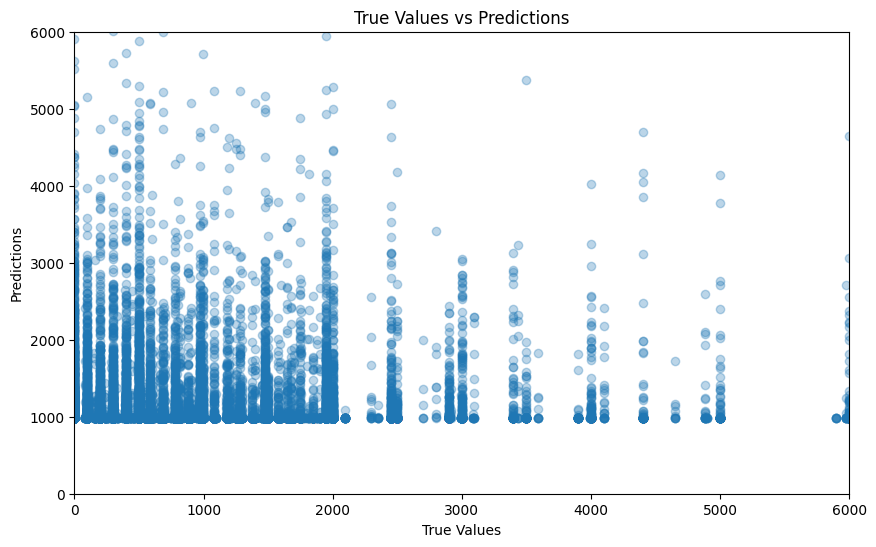

In [30]:
# Plot true values vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(test_labels, predictions, alpha=0.3)
plt.xlim(0  , 6000 + 1)
plt.ylim(0 , 6000 + 1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()

Upon analyzing the predictions generated by our Convolutional Neural Network model, an important discrepancy emerged: the minimum predicted game price was 977 EUR cents, despite the presence of numerous observations in the training labels dataset below this threshold. This realization prompted a deeper investigation into the root cause of this anomaly. Throughout the training process, our focus remained primarily on evaluating the model's performance using metrics such as Mean Squared Error and Mean Absolute Error that we have mentioned in the previous comments. However, it wasn't until the conclusion of the training phase, when the final CNN structure had been selected, that we conducted a scatterplot analysis. This analysis shed light on the evident issue, indicating a clear divergence between the predicted prices and the actual price distribution in the training dataset. While we had anticipated challenges due to the significant computational demands of processing vast image datasets and training complex CNN architectures, this unexpected discrepancy posed a new and perplexing challenge that we had yet to decipher despite our earnest efforts.

## Prediction based in multiple images
To predict the price of a video game based on multiple images and subsequently average these predictions, our proposal is straightforward: compute the mean of the predicted prices generated from each image associated with the game. This averaging process provides a consolidated prediction that considers the collective information from all the game's screenshots, offering a more robust estimate of the game's price. By averaging the predictions, we aim to reduce the potential impact of outliers or inconsistencies in individual predictions, resulting in a more stable and reliable estimation. This approach leverages the cumulative predictive power of multiple images to enhance the accuracy of the final price prediction, thereby improving the overall effectiveness of our model. We present here an exemple for three videogames.


In [41]:

scaler = StandardScaler()
start_index = 21
end_index = 26
images_subset = test_images[21:(26+1)]
labels_subset = test_labels[21:(26+1)]
# Convertir la lista de imágenes en un array numpy
images_array = np.array(images_subset)

test_labels_scaled = scaler.fit_transform(test_labels.reshape(-1, 1)).flatten()

predictions_scaled = model.predict(images_array)

# De-standardize the predictions
predictions = scaler.inverse_transform(predictions_scaled)

# Calcular la media de las predicciones
mean_prediction = np.mean(predictions)
print(f"Mean prediction for a videogame with appid 1020790 is {mean_prediction}, while the true price is {labels_subset[1]} ")

scaler = StandardScaler()
start_index = 27
end_index = 75
images_subset = test_images[start_index:(end_index +1)]
labels_subset = test_labels[start_index:(end_index +1)]
# Convertir la lista de imágenes en un array numpy
images_array = np.array(images_subset)

test_labels_scaled = scaler.fit_transform(test_labels.reshape(-1, 1)).flatten()

predictions_scaled = model.predict(images_array)

# De-standardize the predictions
predictions = scaler.inverse_transform(predictions_scaled)

# Calcular la media de las predicciones
mean_prediction = np.mean(predictions)
print(f"Mean prediction for a videogame with appid 2826410 is {mean_prediction}, while the true price is {labels_subset[1]} ")

scaler = StandardScaler()
start_index = 46
end_index = 58
images_subset = test_images[start_index:(end_index +1)]
labels_subset = test_labels[start_index:(end_index +1)]
# Convertir la lista de imágenes en un array numpy
images_array = np.array(images_subset)

test_labels_scaled = scaler.fit_transform(test_labels.reshape(-1, 1)).flatten()

predictions_scaled = model.predict(images_array)

# De-standardize the predictions
predictions = scaler.inverse_transform(predictions_scaled)

# Calcular la media de las predicciones
mean_prediction = np.mean(predictions)
print(f"Mean prediction for a videogame with appid 1537910 is {mean_prediction}, while the true price is {labels_subset[1]} ")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Mean prediction for a videogame with appid 1020790 is 1312.0826416015625, while the true price is 5998 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Mean prediction for a videogame with appid 2826410 is 1066.42138671875, while the true price is 2450 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Mean prediction for a videogame with appid 2826410 is 1049.9200439453125, while the true price is 1950 


## Neural Network Interpretability
In this last section, we embark on the implementation of interpretability techniques tailored to our Convolutional Neural Network. Firstly, interpretability techniques offer insights into how the model processes input data and makes predictions, enabling us to discern patterns, features, and biases inherent in the model's learned representations. 

We delve into the implementation of Grad-CAM (Gradient-weighted Class Activation Mapping) within our convolutional layer. Grad-CAM is a powerful interpretability technique designed to detect the regions of an input image that are crucial for the model's prediction. It achieves this by generating a heatmap that highlights the important regions of the image, providing visual signs on where the model focuses its attention. By visualizing the regions of interest, we can discern which features or patterns are pivotal for the model's predictions, facilitating a deeper understanding of its behavior.

We have made several attempts to implement Grad-CAM within our project, dedicating considerable time and effort to its integration. Despite our best efforts, we encountered challenges that prevented us from successfully implementing this technique within the available time. As a result, this aspect of the project remains pending for further development if the project is continued at a later time. While we acknowledge the importance of Grad-CAM in enhancing the interpretability of our convolutional neural network (CNN) model, we must prioritize other aspects of the project given the time constraints. Nonetheless, this serves as an opportunity for future exploration and refinement, allowing us to delve deeper into interpretability techniques and further augment the transparency of our model's decision-making process. We present here the functions that we have been developing.


In [ ]:

def get_grad_cam(model, img_array, layer_name):
    grad_model = Model(inputs=model.inputs, outputs=[model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]  # Assuming single output for regression (price)
    
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]
    
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    return heatmap

def overlay_heatmap(heatmap, img_path):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_img = heatmap * 0.4 + img
    return superimposed_img

